# **1. 데이터셋 준비**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import os
import json
import zipfile
import random
import numpy as np
from PIL import Image

## **1-1. 데이터셋 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**이미지 파일 압축 해제**
- 본인 경로를 제대로 설정했는지 확인
- 세션 디스크에 `data > train` 폴더를 만들어두고 압축 해제 진행하셔야 합니다..!
  - 세션 디스크 내 임시 경로로, 드라이브 x

```
!unzip (데이터 경로) -d (압축 해제할 경로)
```

In [ ]:
### 이미지 파일 압축 해제

!unzip /content/drive/MyDrive/6th-project/final/data/train.zip -d /content/data/train
!unzip /content/drive/MyDrive/6th-project/final/data/val.zip -d /content/data/val

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/data/train/image_64.jpg  
  inflating: /content/data/train/image_640.jpg  
  inflating: /content/data/train/image_6400.jpg  
  inflating: /content/data/train/image_6401.jpg  
  inflating: /content/data/train/image_6402.jpg  
  inflating: /content/data/train/image_6403.jpg  
  inflating: /content/data/train/image_6404.jpg  
  inflating: /content/data/train/image_6405.jpg  
  inflating: /content/data/train/image_6406.jpg  
  inflating: /content/data/train/image_6407.jpg  
  inflating: /content/data/train/image_6408.jpg  
  inflating: /content/data/train/image_6409.jpg  
  inflating: /content/data/train/image_641.jpg  
  inflating: /content/data/train/image_6410.jpg  
  inflating: /content/data/train/image_6411.jpg  
  inflating: /content/data/train/image_6412.jpg  
  inflating: /content/data/train/image_6413.jpg  
  inflating: /content/data/train/image_6414.jpg  
  inflating: /content/data/train/image_6415.jpg  
  inflating: /cont

In [ ]:
### images 파일 준비

train_img_path = '/content/data/train'
val_img_path = '/content/data/val'

In [ ]:
### annotations 파일 준비

train_annotations_path = '/content/drive/MyDrive/6th-project/final/data/coco_train.json'
val_annotations_path = '/content/drive/MyDrive/6th-project/final/data/coco_val.json'

## **1-2. Custom Dataset 준비**

In [ ]:
### Custom Dataset 클래스 정의

class FashionDataset(Dataset):
  def __init__(self, annotation_file, image_dir, transform = None):
    with open(annotation_file, 'r') as f:
      self.coco_data = json.load(f)
    self.image_dir = image_dir
    self.transform = transform

  def __len__(self):
    return len(self.coco_data['annotations'])

  def __getitem__(self, idx):
    ## 속성 정보
    annotation = self.coco_data['annotations'][idx]

    ## 이미지
    image_id = annotation['image_id']

    image_info = next((img for img in self.coco_data['images'] if img['id'] == image_id), None)
    image_path = os.path.join(self.image_dir, image_info['file_name'])

    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    ## 캡션
    caption = annotation['caption']

    ## 속성
    attributes = annotation['attributes']

    ## 카테고리
    category = annotation['category']

    return image, caption, attributes, category

In [ ]:
## 데이터셋 준비

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = FashionDataset(annotation_file = train_annotations_path,
                               image_dir = train_img_path,
                               transform = transform)

In [ ]:
val_dataset = FashionDataset(annotation_file = val_annotations_path,
                               image_dir = val_img_path,
                               transform = transform)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, captions, attributes, categories = zip(*batch)

    # attributes 패딩 (빈 문자열로 패딩)
    max_attr_length = max(len(attr) for attr in attributes)
    padded_attributes = [attr + [""] * (max_attr_length - len(attr)) for attr in attributes]

    # 나머지는 그대로 처리
    images = torch.stack(images)
    captions = list(captions)
    categories = list(categories)

    return images, captions, padded_attributes, categories

In [ ]:
### DataLoader 설정

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False, collate_fn = collate_fn)

# **2. Setup**

In [ ]:
!pip install peft

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import AdamW, get_cosine_schedule_with_warmup

from tqdm import tqdm
import matplotlib.pyplot as plt

from peft import get_peft_model, LoraConfig

## **2-1. model 준비**

In [ ]:
### Pre-trained model 불러오기

# 전처리기
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", do_rescale=False)

# 모델
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
### 장치 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1024,),

In [ ]:
### target layer 가져오기
# 특정한 pattern으로 탐색

def get_target_modules(model, patterns):
    target_modules = []
    for name, module in model.named_modules():
        for pattern in patterns:
            if pattern in name:
                target_modules.append(name)
    return target_modules

In [ ]:
## 예시
# 조합에 따라 바꿔야함(layer 찍어서 구조 확인해보기)

decoder_patterns = ["self.query", "self.key", "self.value", "intermediate.dense", "output.dense"]
# encoder_patterns = ["self_attn.qkv", "mlp.fc"]

# encoder_modules = get_target_modules(model, encoder_patterns)[-18:] # 마지막 6개 layer만 가져오려고..
                                                                    # 조건에 따라 바꿔야 함
decoder_modules = get_target_modules(model, decoder_patterns)

target_modules = decoder_modules

In [ ]:
# 레이어 구조 세부 정보 출력
for name, module in model.named_modules():
    print(f"Module Name: {name}")
    print(f"Module Type: {type(module)}")
    print(f"Module Details: {module}")
    print("="*50)

Module Name: 
Module Type: <class 'transformers.models.blip.modeling_blip.BlipForConditionalGeneration'>
Module Details: BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2)

In [ ]:
## PEFT + LoRA 설정

## LoRA Configuration
lora_config = LoraConfig(
    r = 16, # LoRA의 rank
    lora_alpha = 32, # LoRA의 alpha
    lora_dropout = 0.05, # LoRA의 dropout 비율
    target_modules = target_modules,
    bias = "none"
)

# LoRA 적용 모델
peft_model = get_peft_model(model, lora_config)

In [ ]:
for modules in peft_model.targeted_module_names:
  print(modules)

text_decoder.bert.encoder.layer.0.attention.self.query
text_decoder.bert.encoder.layer.0.attention.self.key
text_decoder.bert.encoder.layer.0.attention.self.value
text_decoder.bert.encoder.layer.0.attention.output.dense
text_decoder.bert.encoder.layer.0.crossattention.self.query
text_decoder.bert.encoder.layer.0.crossattention.self.key
text_decoder.bert.encoder.layer.0.crossattention.self.value
text_decoder.bert.encoder.layer.0.crossattention.output.dense
text_decoder.bert.encoder.layer.0.intermediate.dense
text_decoder.bert.encoder.layer.0.output.dense
text_decoder.bert.encoder.layer.1.attention.self.query
text_decoder.bert.encoder.layer.1.attention.self.key
text_decoder.bert.encoder.layer.1.attention.self.value
text_decoder.bert.encoder.layer.1.attention.output.dense
text_decoder.bert.encoder.layer.1.crossattention.self.query
text_decoder.bert.encoder.layer.1.crossattention.self.key
text_decoder.bert.encoder.layer.1.crossattention.self.value
text_decoder.bert.encoder.layer.1.crossatt

## **2-2. Semantic metrics**

### **attribute-level semantic(ALS)**
- 이미지 속성들을 더 많이 포함한 문장을 생성하도록 유도
- 생성된 caption이 데이터의 속성을 얼마나 잘 포함하고 있는지 평가
    - 생성된 문장과 참조 문장에서 공통 attributes의 비율을 계산
    - 단순 개수 비교
- `reference_caption`에 적절한 속성이 없는 경우 보상을 0으로 설정하여 문제가 발생하지 않도록 하고 있음

In [ ]:
import spacy

# SpaCy 모델 로드
nlp = spacy.load("en_core_web_sm")

In [ ]:
def extract_attributes(caption):
    doc = nlp(caption)
    attributes = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']]
    return attributes

In [ ]:
def compute_als(generated_caption, reference_attributes):
    generated_attributes = extract_attributes(generated_caption)

    # 패딩된 속성 제거(공백)
    reference_attributes = [attr for attr in reference_attributes if attr != ""]

    common_attributes = set(generated_attributes) & set(reference_attributes)
    return len(common_attributes) / len(reference_attributes) if reference_attributes else 0

### **sentence-level semantic(SLS)**
- 패션 아이템의 카테고리를 더 정확하게 설명하도록 생성된 문장을 유도
- 생성된 caption이 category를 반영하고 있는지 평가
    - 포함되면 1, 아니면 0

In [ ]:
def load_category_wordmap(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

category_wordmap = load_category_wordmap('/content/drive/MyDrive/6th-project/final/data/cates_wordmap.json')

In [ ]:
def get_category_from_caption(caption):
    caption_words = set(caption.lower().split())
    for cat_id, cat_name in category_wordmap.items():
        if cat_name.lower() in caption_words:
            return int(cat_id)
    return None

In [ ]:
def compute_sls(generated_caption, reference_category):
    predicted_category = get_category_from_caption(generated_caption)
    return 1.0 if predicted_category == reference_category else 0.0

### **전체 보상 함수**

In [ ]:
def compute_rewards(preds, attributes, categories):
    als_rewards = [compute_als(pred, attr) for pred, attr in zip(preds, attributes)]
    sls_rewards = [compute_sls(pred, cat) for pred, cat in zip(preds, categories)]

    return als_rewards, sls_rewards

## **2-3. 평가 지표 준비**

In [ ]:
!git clone https://github.com/salaniz/pycocoevalcap
!pip install git+https://github.com/salaniz/pycocoevalcap.git

fatal: destination path 'pycocoevalcap' already exists and is not an empty directory.
  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-5bdkfew9
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-5bdkfew9
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done


In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

In [ ]:
### 평가 지표 계산

def compute_metrics(preds, labels):
    scorers = [
        (Bleu(4), "BLEU-4"),
        (Meteor(), "METEOR"),
        (Rouge(), "ROUGE"),
        (Cider(), "CIDEr"),
        (Spice(), "SPICE")
    ]

    results = {}
    for scorer, method in scorers:
        score, _ = scorer.compute_score({i: [labels[i]] for i in range(len(labels))}, {i: [preds[i]] for i in range(len(preds))})
        results[method] = score if isinstance(score, float) else score[-1]

    return results

# **3. Fine-tuning**

## **3-1. 학습 & 검증**

In [ ]:
### 옵티마이저 및 Learning Rate Schedule 정의

## 옵티마이저
optimizer = AdamW(filter(lambda p: p.requires_grad, peft_model.parameters()),
                  lr = 2e-5, weight_decay = 0.05)

## learning rate schedule
num_training_steps = len(train_loader) * 10  # 10 에포크
num_warmup_steps = int(0.1 * num_training_steps)  # Warmup 비율 10%
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = num_warmup_steps,
                                            num_training_steps = num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

bleu_scores = []
meteor_scores = []
rouge_scores = []
cider_scores = []
spice_scores = []

In [ ]:
def train(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs, start_epoch=0, lambda_1=0.5, lambda_2=0.5):
    global best_val_loss

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f"=== Epoch {epoch+1} ===")
        print("-" * 20)

        model.train()
        epoch_train_loss = 0

        for images, captions, attributes, categories in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            inputs = processor(images=images, text=captions, return_tensors="pt", padding=True).to(device)

            outputs = model(**inputs, labels=inputs.input_ids)
            mle_loss = outputs.loss

            generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=50)
            generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
            als_rewards, sls_rewards = compute_rewards(generated_texts, attributes, categories)

            # MLE 손실 및 gradient 계산
            optimizer.zero_grad()
            mle_loss.backward(retain_graph=True)

            # REINFORCE를 통한 reward gradient 계산
            log_probs = torch.nn.functional.log_softmax(outputs.logits, dim=-1)
            input_ids_expanded = inputs.input_ids.unsqueeze(-1)
            gathered_log_probs = log_probs.gather(2, input_ids_expanded).squeeze(-1)

            batch_size, seq_length = gathered_log_probs.size()
            reward = torch.tensor(als_rewards, device=device).unsqueeze(1).expand(batch_size, seq_length)

            baseline = reward.mean()
            reinforce_loss = -torch.mean((reward - baseline) * gathered_log_probs)
            reinforce_loss.backward()

            optimizer.step()
            scheduler.step()

            total_loss = 0.5 * mle_loss + 0.5 * reinforce_loss
            epoch_train_loss += total_loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f"Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        epoch_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, captions, attributes, categories in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}"):
                images = images.to(device)
                inputs = processor(images=images, text=captions, return_tensors="pt", padding=True).to(device)

                outputs = model(**inputs, labels=inputs.input_ids)
                val_loss = outputs.loss
                epoch_val_loss += val_loss.item()

                generated_ids = model.generate(pixel_values=inputs.pixel_values, max_length=50)
                generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

                all_preds.extend(generated_texts)
                all_labels.extend(captions)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Calculate evaluation metrics
        metrics = compute_metrics(all_preds, all_labels)

        bleu_scores.append(metrics['BLEU-4'])
        meteor_scores.append(metrics['METEOR'])
        rouge_scores.append(metrics['ROUGE'])
        cider_scores.append(metrics['CIDEr'])
        spice_scores.append(metrics['SPICE'])

        print(f"BLEU: {metrics['BLEU-4']:.4f}, METEOR: {metrics['METEOR']:.4f}, ROUGE: {metrics['ROUGE']:.4f}, CIDEr: {metrics['CIDEr']:.4f}, SPICE: {metrics['SPICE']:.4f}")

        # Best model 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/6th-project/final/model/model_trial_2.pth") # 모델명 trial에 맞게 바꿔주세요.
            print(f"Model saved at Epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

        # Clear cache
        torch.cuda.empty_cache()

In [ ]:
# 모델 학습

num_epochs = 10
train(peft_model, train_loader, val_loader, optimizer, scheduler, device, num_epochs)

## **3-2. 결과 시각화**

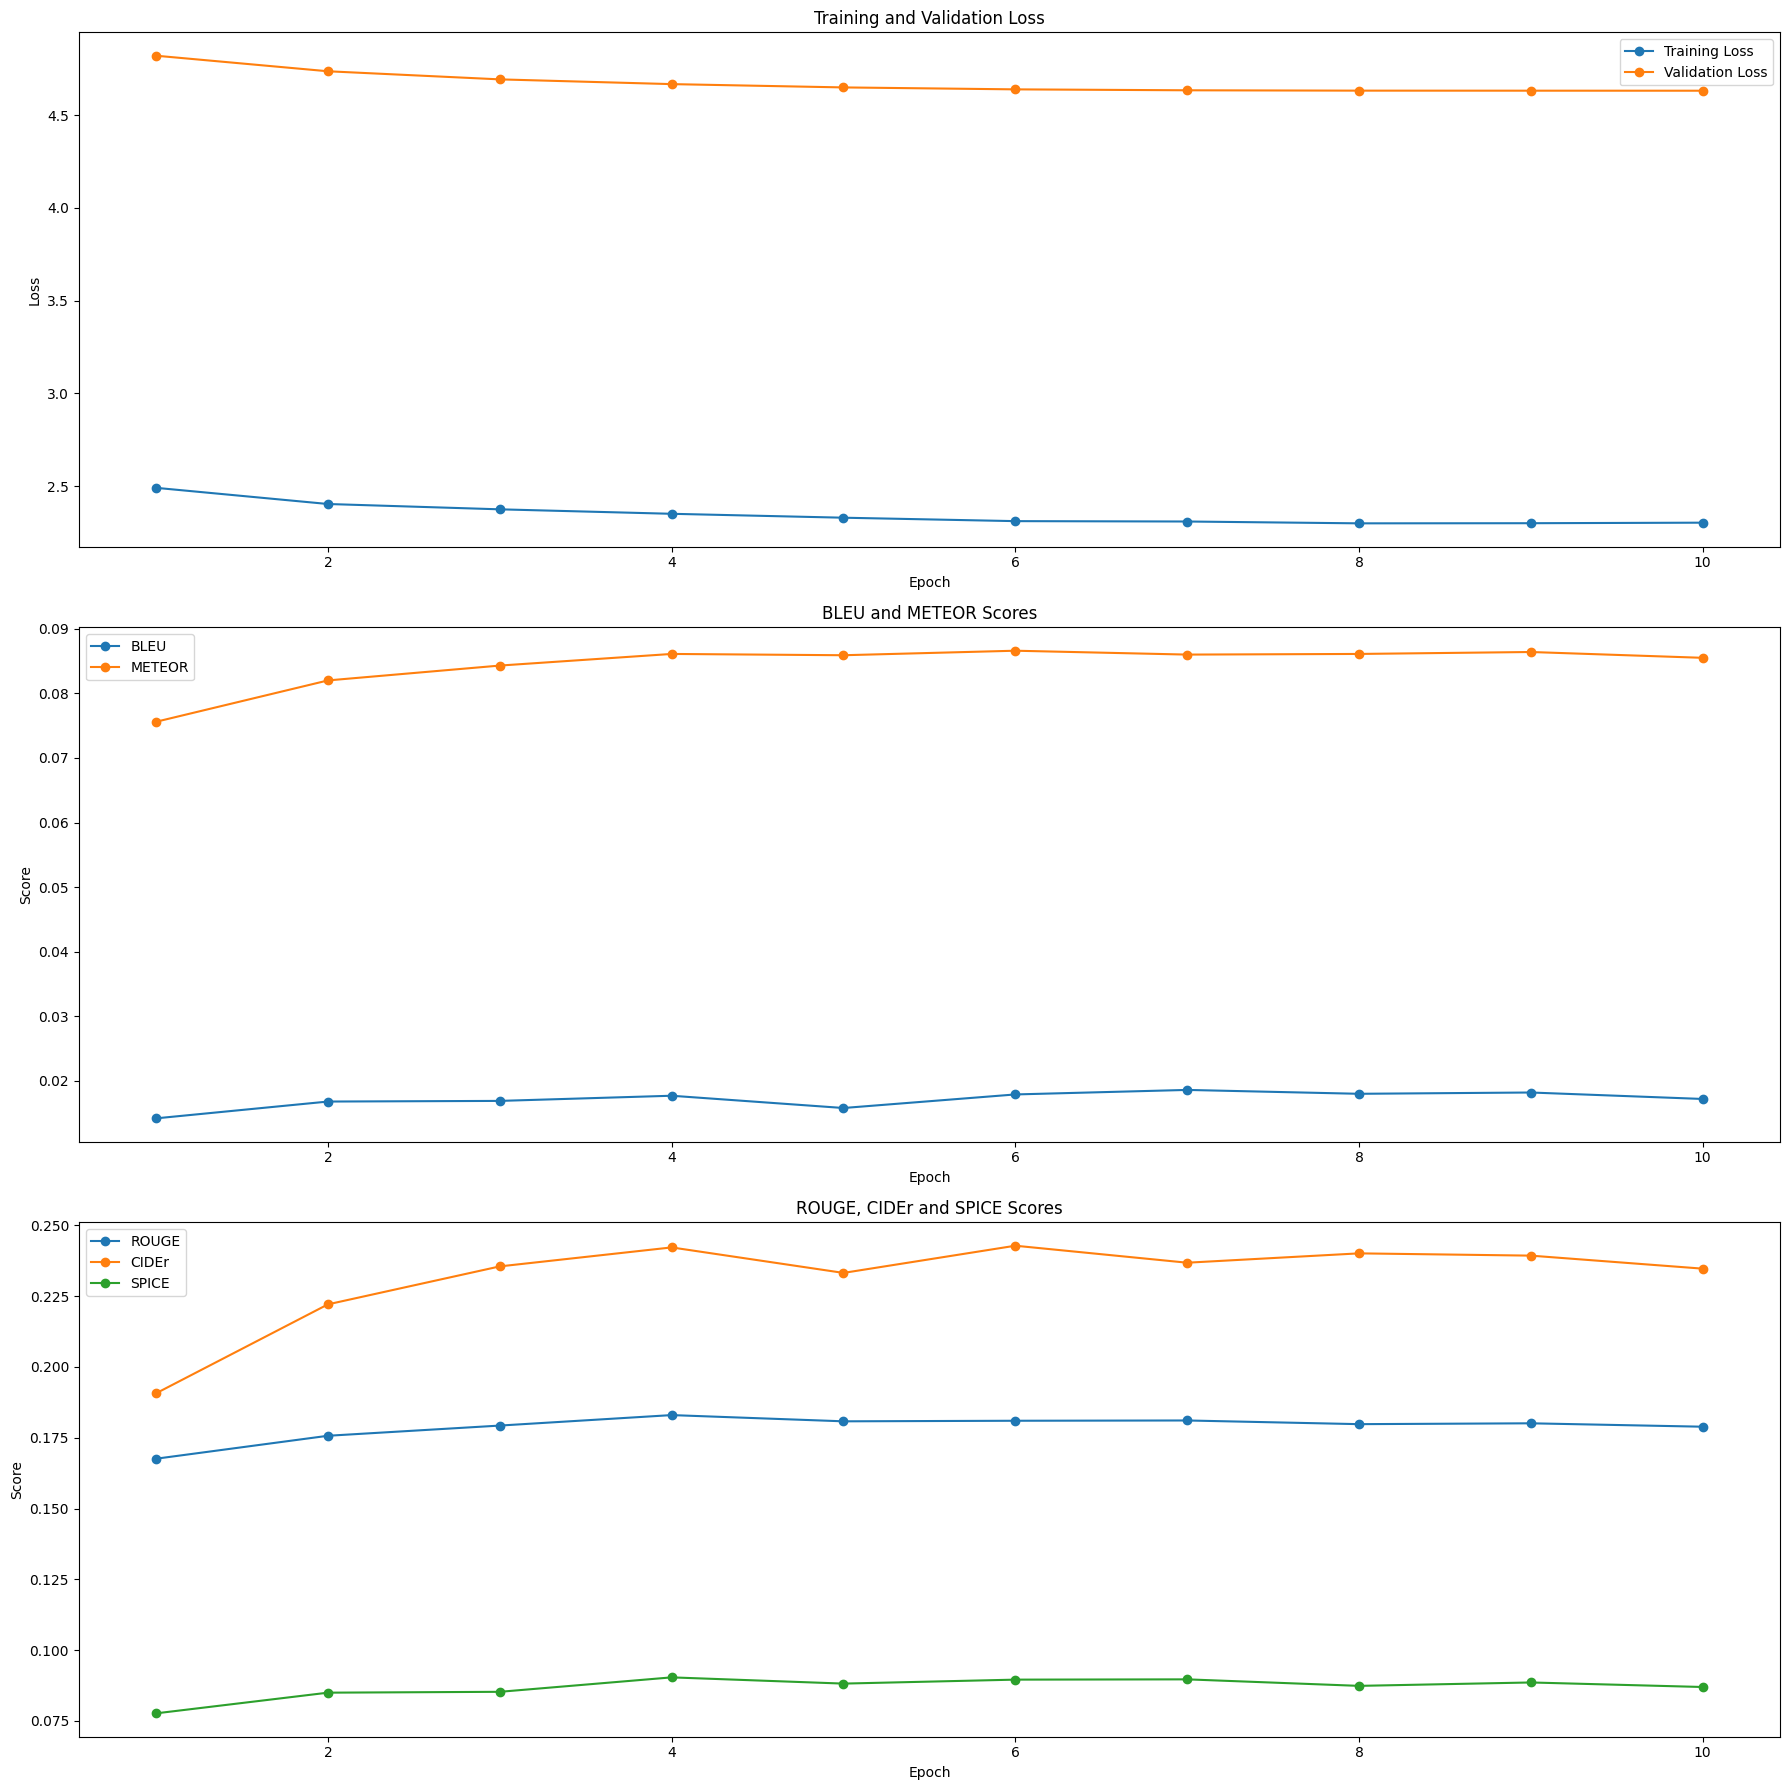

In [ ]:
### 시각화

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(18, 18))

# 손실 곡선
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 평가 지표 1 (BLEU, METEOR)
plt.subplot(3, 1, 2)
plt.plot(epochs, bleu_scores, marker='o', label='BLEU')
plt.plot(epochs, meteor_scores, marker='o', label='METEOR')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('BLEU and METEOR Scores')
plt.legend()

# 평가 지표 2 (ROUGE, CIDEr, SPICE)
plt.subplot(3, 1, 3)
plt.plot(epochs, rouge_scores, marker='o', label='ROUGE')
plt.plot(epochs, cider_scores, marker='o', label='CIDEr')
plt.plot(epochs, spice_scores, marker='o', label='SPICE')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('ROUGE, CIDEr and SPICE Scores')
plt.legend()

plt.tight_layout()
plt.show()